# Proyecto Machine Learning - Clasificacion de imagenes
# -- Clasificacion si una persona porta o no mascarilla --
## Grupo: 6CV3
## Integrantes:
* Pérez Mongragón Eduardo
* Rosiles Hidalgo Emanuel

# VGG19

In [57]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications.resnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Preprocesamiento - Redimensionamiento de imagenes de entrenamiento

In [ ]:
def redimencionar_imagenes(dataset_path, target_size, nombre_clase, nombre_carpeta):
    resized_path = os.path.join(dataset_path, nombre_carpeta)
    os.makedirs(resized_path, exist_ok=True)

    original_path = os.path.join(dataset_path, nombre_clase)

    file_list = os.listdir(original_path)

    # Itera sobre los archivos de cada imagen y redimensiona cada una
    for file_name in file_list:
        original_image_path = os.path.join(original_path, file_name)
        image = Image.open(original_image_path)
        resized_image = image.resize(target_size)
        resized_image_path = os.path.join(resized_path, file_name)
        resized_image.save(resized_image_path)

# ------------------------------ Solo correr la primera vez ------------------------------

dataset_path_train = "./Train"

# Parámetros de preprocesamiento de imágenes
img_size = (64, 64)
batch_size = 32

redimencionar_imagenes(dataset_path_train, img_size, "WithMask", "WithMask_resize") 
redimencionar_imagenes(dataset_path_train, img_size, "WithoutMask", "WithoutMask_resize") 

# Definición del modelo

In [60]:
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Congelar las capas convolucionales del modelo VGG19
for layer in vgg.layers:
    layer.trainable = False

# Aplanamiento de la ultima capa
x = Flatten()(vgg.output)

# Creacion de una nueva capa de salida para clasificacion
prediction = Dense(2, activation = 'softmax' )(x)

model = Model( inputs = vgg.input , outputs = prediction )

model.compile( loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'] )

#Guardar pesos iniciales para reutilizar el modelo
pesos_iniciales = model.get_weights()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

# Aplicación de Hold Out en el banco de imágenes

In [61]:
# Rutas de los directorios de las imágenes de cada clase
directorio_clase_1 = './Train/WithMask_resize'
directorio_clase_2 = './Train/WithoutMask_resize'

# Lista para almacenar las imágenes y las etiquetas
imagenes = []
etiquetas = []

# Recorrer el directorio de la clase 1 y cargar las imágenes
for archivo in os.listdir(directorio_clase_1):
    ruta_imagen = os.path.join(directorio_clase_1, archivo)
    imagen = load_img(ruta_imagen, target_size=(64, 64))
    imagen = img_to_array(imagen)
    imagenes.append(imagen)
    etiquetas.append(0)  # Etiqueta para la clase 1

# Recorrer el directorio de la clase 2 y cargar las imágenes
for archivo in os.listdir(directorio_clase_2):
    ruta_imagen = os.path.join(directorio_clase_2, archivo)
    imagen = load_img(ruta_imagen, target_size=(64, 64))
    imagen = img_to_array(imagen)
    imagenes.append(imagen)
    etiquetas.append(1)  # Etiqueta para la clase 2

# Convertir las listas a arreglos numpy
imagenes = np.array(imagenes)
etiquetas = np.array(etiquetas)
etiquetas = to_categorical(etiquetas, num_classes=2)


In [62]:
# Aplicacion de hold out al banco de datos
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [63]:
image_size = X_train.shape[1:3]
print("Tamaño de las imágenes en X_train:", image_size)

Tamaño de las imágenes en X_train: (64, 64)


In [64]:
# Normalizacion de los valores de los pixeles
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255) 
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Aplicacion de normalizacion y division por lotes de los distintos conjuntos de imagenes
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

print(f'Entrenamiento: {train_generator.n}')
print(f'Validación: {val_generator.n}')
print(f'Prueba: {test_generator.n}')

Entrenamiento: 6400
Validación: 1600
Prueba: 2000


# Entrenamiento con 10 épocas

In [65]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

model.save("modelo_64x64_10Epocs_HoldOut_VGG19.h5")

Epoch 1/10
200/200 [==============================] - 107s 531ms/step - loss: 0.1889 - accuracy: 0.9256 - val_loss: 0.1245 - val_accuracy: 0.9544
Epoch 2/10
200/200 [==============================] - 116s 583ms/step - loss: 0.0967 - accuracy: 0.9667 - val_loss: 0.0958 - val_accuracy: 0.9681
Epoch 3/10
200/200 [==============================] - 123s 613ms/step - loss: 0.0760 - accuracy: 0.9767 - val_loss: 0.0834 - val_accuracy: 0.9725
Epoch 4/10
200/200 [==============================] - 116s 581ms/step - loss: 0.0646 - accuracy: 0.9786 - val_loss: 0.0783 - val_accuracy: 0.9744
Epoch 5/10
200/200 [==============================] - 103s 518ms/step - loss: 0.0564 - accuracy: 0.9798 - val_loss: 0.0700 - val_accuracy: 0.9781
Epoch 6/10
200/200 [==============================] - 103s 514ms/step - loss: 0.0506 - accuracy: 0.9834 - val_loss: 0.0748 - val_accuracy: 0.9756
Epoch 7/10
200/200 [==============================] - 103s 514ms/step - loss: 0.0461 - accuracy: 0.9836 - val_loss: 0.0679 -

# Métricas

In [66]:
# Evaluacion del rendimiento del modelo 
loss, accuracy = model.evaluate(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

63/63 [==============================] - 26s 415ms/step - loss: 0.0591 - accuracy: 0.9745
Test: accuracy = 0.974500  ;  loss = 0.059087 


63/63 [==============================] - 27s 410ms/step


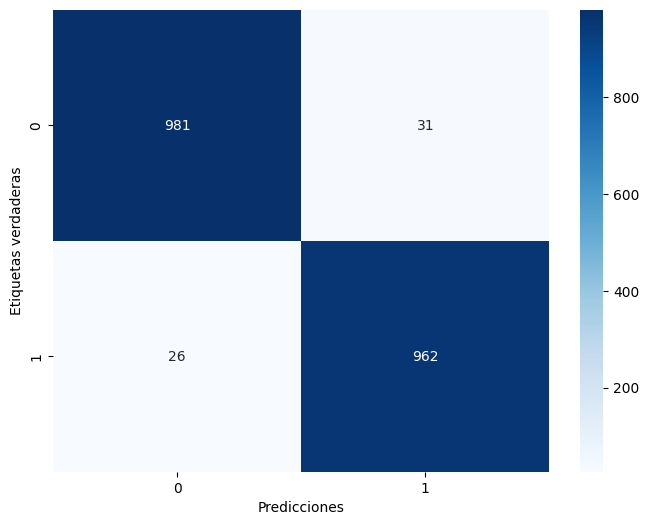

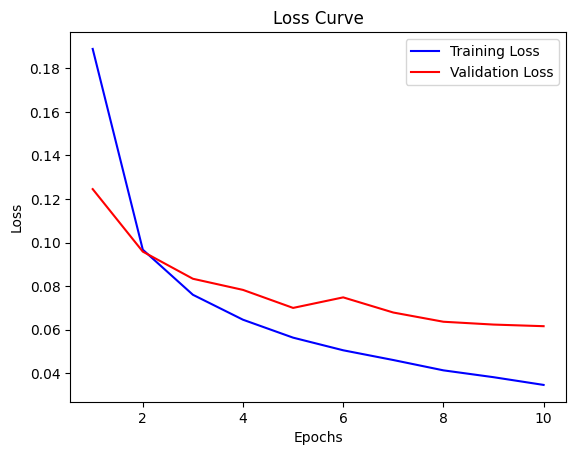

In [67]:
# Obtener predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()

# Obtener valores de pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear gráfico de la curva de pérdida
plt.plot(range(1, len(train_loss) + 1), train_loss, 'b', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, 'r', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
report = classification_report(y_true, y_pred_classes, target_names=['WithMask','WithoutMask'])
print(report)

              precision    recall  f1-score   support

    WithMask       0.97      0.97      0.97      1012
 WithoutMask       0.97      0.97      0.97       988

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



# Entrenamiento con 20 épocas

In [69]:
#Reiniciar pesos en el modelo
model.set_weights(pesos_iniciales)

In [70]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)


model.save("modelo_64x64_20Epocs_HoldOut_VGG19.h5")

Epoch 1/20
200/200 [==============================] - 104s 518ms/step - loss: 0.1448 - accuracy: 0.9422 - val_loss: 0.0943 - val_accuracy: 0.9663
Epoch 2/20
200/200 [==============================] - 104s 522ms/step - loss: 0.0778 - accuracy: 0.9739 - val_loss: 0.0840 - val_accuracy: 0.9731
Epoch 3/20
200/200 [==============================] - 103s 516ms/step - loss: 0.0619 - accuracy: 0.9789 - val_loss: 0.0763 - val_accuracy: 0.9756
Epoch 4/20
200/200 [==============================] - 103s 517ms/step - loss: 0.0527 - accuracy: 0.9819 - val_loss: 0.0770 - val_accuracy: 0.9737
Epoch 5/20
200/200 [==============================] - 103s 517ms/step - loss: 0.0490 - accuracy: 0.9844 - val_loss: 0.0686 - val_accuracy: 0.9769
Epoch 6/20
200/200 [==============================] - 104s 522ms/step - loss: 0.0436 - accuracy: 0.9856 - val_loss: 0.0663 - val_accuracy: 0.9775
Epoch 7/20
200/200 [==============================] - 103s 514ms/step - loss: 0.0390 - accuracy: 0.9869 - val_loss: 0.0633 -

In [75]:
# Evaluacion del rendimiento del modelo 
loss, accuracy = model.evaluate(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

63/63 [==============================] - 29s 462ms/step - loss: 0.0803 - accuracy: 0.9690
Test: accuracy = 0.969000  ;  loss = 0.080343 


63/63 [==============================] - 26s 410ms/step


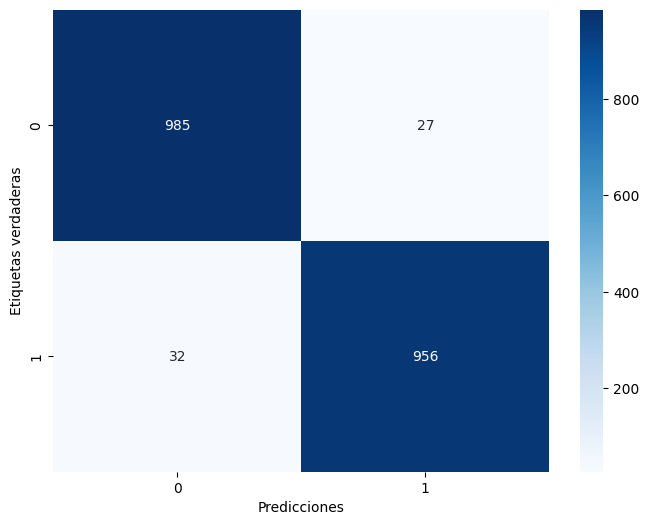

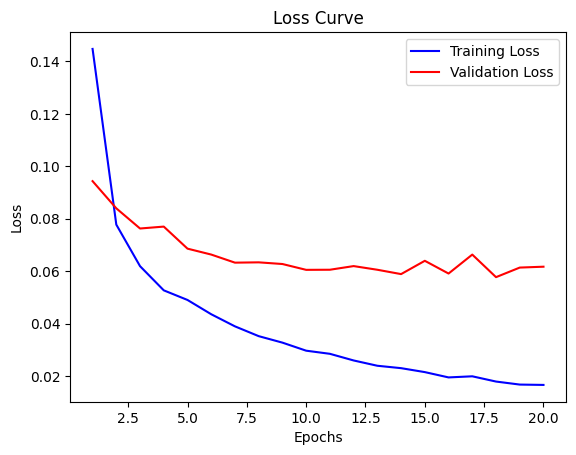

In [71]:
# Evaluar el modelo en los datos de prueba
model = load_model("modelo_64x64_20Epocs_HoldOut_VGG19.h5")
with open('history_20Epocs_vgg19.pkl', 'rb') as file:
    history = pickle.load(file)

# Obtener predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()

# Obtener valores de pérdida
train_loss = history['loss']
val_loss = history['val_loss']

# Crear gráfico de la curva de pérdida
plt.plot(range(1, len(train_loss) + 1), train_loss, 'b', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, 'r', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [76]:
report = classification_report(y_true, y_pred_classes, target_names=['WithMask','WithoutMask'])
print(report)

              precision    recall  f1-score   support

    WithMask       0.97      0.97      0.97      1012
 WithoutMask       0.97      0.97      0.97       988

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



# Pruebas 

# 10 Épocas

In [83]:
model = load_model("modelo_64x64_10Epocs_HoldOut_VGG19.h5")
prueba_dir = "Prueba"

clases_etiquetas = {
    0: "WithMask",
    1: "WithoutMask",
}

# Lista para almacenar los nombres de archivo y las predicciones
predicciones = []

# Recorre los archivos en la carpeta de prueba
for filename in os.listdir(prueba_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Asegúrate de que solo se consideren archivos de imagen
        # Ruta completa de la imagen
        imagen_path = os.path.join(prueba_dir, filename)

        # Carga la imagen
        image = Image.open(imagen_path)
        image = image.convert("RGB")

        # Preprocesa la imagen
        image = image.resize((64, 64))
        image_array = np.array(image)
        image_array = image_array / 255.0
        input_array = np.expand_dims(image_array, axis=0)

        # Realiza la predicción
        prediction = model.predict(input_array)
        predicted_class = np.argmax(prediction)

        # Obtén la etiqueta correspondiente al número de clase
        clase_etiqueta = clases_etiquetas[predicted_class]

        # Guarda el nombre del archivo, la predicción y la etiqueta en la lista
        predicciones.append((filename, predicted_class, clase_etiqueta))

# Imprime las predicciones
for nombre_archivo, clase_predicha, etiqueta in predicciones:
    # Obtener la etiqueta verdadera del archivo
    if "Sin" in nombre_archivo:
        etiqueta_verdadera = "WithoutMask"
    elif "Con" in nombre_archivo:
        etiqueta_verdadera = "WithMask"
    else:
        etiqueta_verdadera = "Etiqueta desconocida"

    # Imprimir la etiqueta verdadera
    print("Etiqueta verdadera:", etiqueta_verdadera)
    print("Etiqueta predicha: ", etiqueta)
    print("Imagen: ", nombre_archivo)
    print()

1/1 [==============================] - 0s 61ms/step
Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  00_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  01_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  02_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  03_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  04_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  05_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  06_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  07_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  08_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  09_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  10_Sin.jpg

Etiqueta verdadera: WithMask
Et

# 20 epocas

In [82]:
model = load_model("modelo_64x64_20Epocs_HoldOut_VGG19.h5")
prueba_dir = "Prueba"

clases_etiquetas = {
    0: "WithMask",
    1: "WithoutMask",
}

# Lista para almacenar los nombres de archivo y las predicciones
predicciones = []

# Recorre los archivos en la carpeta de prueba
for filename in os.listdir(prueba_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Asegúrate de que solo se consideren archivos de imagen
        # Ruta completa de la imagen
        imagen_path = os.path.join(prueba_dir, filename)

        # Carga la imagen
        image = Image.open(imagen_path)
        image = image.convert("RGB")

        # Preprocesa la imagen
        image = image.resize((64, 64))
        image_array = np.array(image)
        image_array = image_array / 255.0
        input_array = np.expand_dims(image_array, axis=0)

        # Realiza la predicción
        prediction = model.predict(input_array)
        predicted_class = np.argmax(prediction)

        # Obtén la etiqueta correspondiente al número de clase
        clase_etiqueta = clases_etiquetas[predicted_class]

        # Guarda el nombre del archivo, la predicción y la etiqueta en la lista
        predicciones.append((filename, predicted_class, clase_etiqueta))

# Imprime las predicciones
for nombre_archivo, clase_predicha, etiqueta in predicciones:
    # Obtener la etiqueta verdadera del archivo
    if "Sin" in nombre_archivo:
        etiqueta_verdadera = "WithoutMask"
    elif "Con" in nombre_archivo:
        etiqueta_verdadera = "WithMask"
    else:
        etiqueta_verdadera = "Etiqueta desconocida"

    # Imprimir la etiqueta verdadera
    print("Etiqueta verdadera:", etiqueta_verdadera)
    print("Etiqueta predicha: ", etiqueta)
    print("Imagen: ", nombre_archivo)
    print()

1/1 [==============================] - 0s 61ms/step
Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  00_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  01_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  02_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  03_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  04_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  05_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  06_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  07_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  08_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  09_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithoutMask
Imagen:  10_Sin.jpg

Etiqueta verdadera: WithMask